In [1]:
%matplotlib inline

In [2]:
import numpy as np
import sympy as sp

import cProfile
import pstats

from my_orbit_lib.epoch import Epoch
from datetime import datetime

from my_orbit_lib.constants import *
from my_orbit_lib.extensions import *
from my_orbit_lib.utils import *
from my_orbit_lib.body import *
from my_orbit_lib.trajectory import *

In [3]:
def plot_trajectory_mars(trajectories=[], body=None, vel_arrow_scale=400, x_view_angle=-75, y_view_angle=25, scale=0.7, save=None):
    """
    Plots the trajectories in a nice visualization.
    
    If body is not None we plot it's current position and velocity vector 
    and use it's name and epoch for the title.
    """
    
    fig = plt.figure()
    plt.title('Trajectory Plot')

    ax = fig.add_subplot(1, 1, 1, projection=Axes3D.name)
    ax.view_init(y_view_angle, x_view_angle)
    ax.set_box_aspect((1, 1, 1))
    ax.grid(False)
    
    # Coordinate system arrows
    RADIUS = strip_units(MARS_RADIUS)
    r = RADIUS * 0.8
    ax.quiver([0], [0], [0], [r], [0], [0], color='r', linewidth = 0.5)
    ax.quiver([0], [0], [0], [0], [r], [0], color='g', linewidth = 0.5)
    ax.quiver([0], [0], [0], [0], [0], [r], color='b', linewidth = 0.5)

    # Plot Mars sphere
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)

    r = RADIUS
    ax.plot_wireframe(x * r, y * r, z * r, color=(0.1, 0.2, 0.5, 0.2), linewidth=0.5)

    # Plot first body position 
    if len(trajectories):
        t = trajectories[0]
        sat_pos, _ = t.points[0]

        label = f'Spacecraft on {t.epoch_begin.todatetime().strftime("%d/%m/%Y, %H:%M:%S UTC")}'
        sat = ax.scatter([sat_pos[0]], [sat_pos[1]], [sat_pos[2]], label=label,color="green")

    # Plot numerical points
    last_point = None
    last_point_t = None
    last_point_landed = False
    
    for trajectory in trajectories:
        if len(trajectory.points) == 0: continue
        
        t_duration = (trajectory.epoch_end.jde - trajectory.epoch_begin.jde) * 86400
        label = ((trajectory.label if trajectory.label is not None else 'Engine Burn') + ' {:.2f}s'.format(t_duration)) if trajectory.is_maneuver else (trajectory.label if trajectory.label is not None else 'Trajectory')
        style = '-.' if trajectory.is_maneuver else '--'
        color = trajectory.color
        
        # If we have at least 3 points to form a path...
        if len(trajectory.points) > 2:
            ax.plot(trajectory.points[:, 0, 0], trajectory.points[:, 0, 1], trajectory.points[:, 0, 2], style, label=label, color=color)
            if trajectory.is_maneuver:
                for p in [trajectory.points[0], trajectory.points[-1]]: 
                    ax.scatter(p[0, 0], p[0, 1], p[0, 2], color=color)
        else:
            # else scatter points
            for p in trajectory.points:
                ax.scatter(p[0, 0], p[0, 1], p[0, 2], color=color)
            ax.scatter(-1000000, 0, 0, label=label, color=color) # Legend hack to make sure only one entry appears
        
        if last_point_t is None or (last_point_t.jde < trajectory.epoch_end.jde):
            last_point = trajectory.points[-1]
            last_point_t = trajectory.epoch_end
            last_point_landed = trajectory.landed

    # Plot last body position 
    if last_point is not None:
        label = f'{"Landing" if last_point_landed else "Spacecraft"} on {last_point_t.todatetime().strftime("%d/%m/%Y, %H:%M:%S UTC")}'

        sat_pos, sat_vel = last_point.copy()
        sat_vel *= vel_arrow_scale
        
        sat = ax.scatter([sat_pos[0]], [sat_pos[1]], [sat_pos[2]], label=label)
        ax.quiver([sat_pos[0]], [sat_pos[1]], [sat_pos[2]], [sat_vel[0]], [sat_vel[1]], [sat_vel[2]], color=sat.get_fc())
    
    # plt.legend(loc='upper left', bbox_to_anchor=(1.3, 1), borderaxespad=0)

    # Rest of plot
    r = RADIUS * scale
    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    ax.set_zlim(-r, r)
    
    ax.set_axis_off()
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.axis('off')
    
    if save is not None:
        plt.savefig(save, format="svg")

    plt.show()

In [4]:
mass_airplane = 2.59 * kilogram
mass_comm_satellite = 100 * kilogram
mass_capsule = 700 * kilogram
mass_deployment_system = 50 * kilogram
mass_fuel = 4000 * kilogram

mass_mission = mass_airplane + mass_comm_satellite + mass_capsule + mass_deployment_system + mass_fuel
mass_mission, mass_mission - mass_fuel

(4852.59*kilogram, 852.59*kilogram)

In [5]:
capsule_diameter = (2.65 + 0.20)
capsule_area = (capsule_diameter/2)**2 * np.pi
capsule_area

6.379396582195774

In [6]:
num_engines = 8
engine_thrust = 400 # newton

specific_impulse = 300
g0 = 9.80665

In [62]:
R_MARS = strip_units(MARS_RADIUS)

@njit
def mars_atmosphere_drag(t, x, v):
    # https://www.grc.nasa.gov/www/k-12/airplane/atmosmrm.html
    alt = (norm(x) - R_MARS) * 1000
    T = -23.4 - 0.0022222 * alt        # m
    p = 0.699 * np.exp(-0.00009 * alt) # kPa
    rho = p/(0.1921 * (T + 273.1))     # kg/m^3

    cd_half_sphere = 0.42
    drag = cd_half_sphere * 0.5 * rho * (norm(v) * 1000)**2 * capsule_area # newtons

    mass_flow = 0 # TODO: Heat shield dissipating mass

    return -v/norm(v) * drag, mass_flow

@njit
def engine(t, x, v):
    thrust = num_engines * engine_thrust
    mass_flow = -thrust / (g0 * specific_impulse) 
    return -v/norm(v) * thrust, mass_flow

@njit
def engine_pro(t, x, v):
    thrust = num_engines * engine_thrust
    mass_flow = -thrust / (g0 * specific_impulse) 
    return v/norm(v) * thrust, mass_flow

@njit
def engine_incl(t, x, v):
    thrust = num_engines * engine_thrust
    mass_flow = -thrust / (g0 * specific_impulse) 
    h = np.cross(x,v)
    return -h/norm(h) * thrust, mass_flow

def get_mission():
    pos_0 = sp.Vector([-18000, 0, -33000]) * kilometer
    vel_0 = sp.Vector([4.1, 0, 4.1]) * kilometer/second   # v near mars approach ~ 5.618

    maneuver = []
    def append_trajectory(t, label = None, color = None):
        body.update(t)
        if label:
            t.label = label
        if color:
            t.color = color
        maneuver.append(t)

    body = Body(pos=pos_0, 
               vel=vel_0,
               epoch=Epoch(datetime.utcnow()),
               name="Mars Orbiter",
               mass=mass_mission)

    print("Beginning, sma:", get_sma(body.pos, body.vel), ", e:", norm(get_eccentricity_vector(body.pos, body.vel)))

    #
    # Get to Mars
    #
    append_trajectory(get_trajectory(body, 
                       until_condition_becomes_false=lambda n, t, x, v: norm(x) > R_MARS * 7,
                       step_size=100,
                       tol=0.1), 
                       "MTO")
    
    vel_0 = norm(body.vel)

    body.external_forces = mars_atmosphere_drag

    #
    # Turn on engines for MOI
    #
    body.engine = engine
    def eccentricity_condition(n, t, x, v):
        e = norm(get_eccentricity_vector(x, v))
        return e > 1

    append_trajectory(get_trajectory(body, 
                       until_condition_becomes_false=eccentricity_condition,
                       step_size=10,
                       tol=0.1),
                       "MOI")

    append_trajectory(get_trajectory(body, 
                        duration=20, 
                        step_size=97, 
                        tol=0.1),
                        "...")

    vel_1 = norm(body.vel)
    delta_v = vel_1 - vel_0

    maneuver[-1].label = f"$\Delta v = {delta_v:.2f}\ km/s$"
    maneuver[-1].is_maneuver = False

    #
    # Turn off engines and wait for periares 
    #
    body.engine = NO_FORCES

    a = get_sma(body.pos, body.vel)
    e = norm(get_eccentricity_vector(body.pos, body.vel))

    velocity_at_periares = np.sqrt(MU_NP / a * (1+e)/(1-e))
    print(body.pos, body.vel, a, e, velocity_at_periares)
    def wait_for_periares(n, t, x, v):
        diff = np.abs(norm(v) - velocity_at_periares)
        return diff > 0.1

    append_trajectory(get_trajectory(body, 
                       until_condition_becomes_false=wait_for_periares,
                       step_size=10,
                       tol=0.1),
                       "Wait for periares",
                       "lightcoral")
    if body.landed: return body, maneuver

    vel_0 = norm(body.vel)

    # 
    # Circularization
    #
    body.engine = engine

    def eccentricity_condition(n, t, x, v):
        e = norm(get_eccentricity_vector(x, v))
        print("E", e)
        return e > 0.3

    append_trajectory(get_trajectory(body, 
                       until_condition_becomes_false=eccentricity_condition,
                       step_size=1,
                       tol=0.1),
                       "Burn to e=0.2",
                       "fuchsia")
    
    vel_1 = norm(body.vel)
    delta_v = vel_1 - vel_0

    append_trajectory(get_trajectory(body, 
                        duration=1, 
                        step_size=1, 
                        tol=0.1),
                        f"$\Delta v = {delta_v:.2f}\ km/s$",
                        "fuchsia")
    maneuver[-1].is_maneuver = False

    if body.landed: return body, maneuver

    #
    # Turn off engines and wait for apoares 
    #
    body.engine = NO_FORCES

    a = get_sma(body.pos, body.vel)
    e = norm(get_eccentricity_vector(body.pos, body.vel))

    velocity_at_apoares = np.sqrt(MU_NP / a * (1-e)/(1+e))
    print(body.pos, body.vel, a, e, velocity_at_apoares)
    def wait_for_apoares(n, t, x, v):
        diff = np.abs(norm(v) - velocity_at_apoares)
        return diff > 0.1

    append_trajectory(get_trajectory(body, 
                       until_condition_becomes_false=wait_for_apoares,
                       step_size=10,
                       tol=0.1),
                       "Wait for apoares",
                       "maroon")
    if body.landed: return body, maneuver

    vel_0 = norm(body.vel)

    # 
    # Drop periares
    #
    body.engine = engine

    def periares_condition(n, t, x, v):
        e = norm(get_eccentricity_vector(x, v))
        periares = get_sma(x, v) * (1 - e)
        hp = periares - R_MARS
        print("hp", hp)
        return hp > 120 

    append_trajectory(get_trajectory(body, 
                       until_condition_becomes_false=periares_condition,
                       step_size=1,
                       tol=0.1),
                       "Burn H_peri = 120 km",
                       "crimson")
    
    vel_1 = norm(body.vel)
    delta_v = vel_1 - vel_0

    append_trajectory(get_trajectory(body, 
                        duration=0.1, 
                        step_size=0.1, 
                        tol=0.1),
                        f"$\Delta v = {delta_v:.2f}\ km/s$",
                        "crimson")
    maneuver[-1].is_maneuver = False
    
    if body.landed: return body, maneuver

    #
    # Aerobraking
    #
    body.engine = NO_FORCES
    
    def apoares_condition(n, t, x, v):
        e = norm(get_eccentricity_vector(x, v))
        apoares = get_sma(x, v) * (1 + e)
        print("apoares", apoares)
        return apoares > 9300 

    append_trajectory(get_trajectory(body, 
                                     until_condition_becomes_false=apoares_condition, 
                                     step_size=100, 
                                     tol=0.1),
                      "Aerobraking till R_p = 9300 km",
                      "tomato")
    
    #
    # Turn off engines and wait for periares 
    #
    body.engine = NO_FORCES

    a = get_sma(body.pos, body.vel)
    e = norm(get_eccentricity_vector(body.pos, body.vel))

    velocity_at_periares = np.sqrt(MU_NP / a * (1+e)/(1-e))
    print(body.pos, body.vel, a, e, velocity_at_periares)
    def wait_for_periares(n, t, x, v):
        diff = np.abs(norm(v) - velocity_at_periares)
        return diff > 0.1

    append_trajectory(get_trajectory(body, 
                       until_condition_becomes_false=wait_for_periares,
                       step_size=10,
                       tol=0.1),
                       "Wait for periares",
                       "lightcoral")

    append_trajectory(get_trajectory(body, 
                        duration=0.1, 
                        step_size=0.1, 
                        tol=0.1),
                        f"CAPSULE ENTRY DEPLOYMENT FROM h=120 km$",
                        "black")
    maneuver[-1].is_maneuver = False

    vel_0 = norm(body.vel)

    #
    # Wait for apoares 
    #
    body.engine = NO_FORCES

    a = get_sma(body.pos, body.vel)
    e = norm(get_eccentricity_vector(body.pos, body.vel))

    velocity_at_apoares = np.sqrt(MU_NP / a * (1-e)/(1+e))
    print(body.pos, body.vel, a, e, velocity_at_apoares)
    def wait_for_apoares(n, t, x, v):
        diff = np.abs(norm(v) - velocity_at_apoares)
        return diff > 0.1

    append_trajectory(get_trajectory(body, 
                       until_condition_becomes_false=wait_for_apoares,
                       step_size=10,
                       tol=0.1),
                       "Wait for apoares",
                       "lightsalmon")
    if body.landed: return body, maneuver

    vel_0 = norm(body.vel)

    # 
    # Raise periares
    #
    body.engine = engine_pro

    def eccentricity_condition(n, t, x, v):
        e = norm(get_eccentricity_vector(x, v))
        print("E2", e)
        return e > 0.2

    append_trajectory(get_trajectory(body, 
                       until_condition_becomes_false=eccentricity_condition,
                       step_size=1,
                       tol=0.1),
                       "Circularization",
                       "blue")
    
    vel_1 = norm(body.vel)
    delta_v = vel_1 - vel_0

    append_trajectory(get_trajectory(body, 
                        duration=0.1, 
                        step_size=0.1, 
                        tol=0.1),
                        f"$\Delta v = {delta_v:.2f}\ km/s$",
                        "blue")
    maneuver[-1].is_maneuver = False

    if body.landed: return body, maneuver

    #
    # Wait for node 
    #
    body.engine = NO_FORCES

    def wait_for_node(n, t, x, v):
        return np.abs(v[1]) > 0.1

    append_trajectory(get_trajectory(body, 
                       until_condition_becomes_false=wait_for_node,
                       step_size=10,
                       tol=0.1),
                       "Wait for node",
                       "darkkhaki")
    if body.landed: return body, maneuver

    vel_0 = norm(body.vel)

    # 
    # Inclination correction
    #
    body.engine = engine_incl

    def inclination_condition(n, t, x, v):
        h = np.cross(x, v)
        i = np.degrees(np.arccos(np.dot(h, np.array([0,1,0])) / (norm(h))))
        print("i", i)
        return i > 70

    append_trajectory(get_trajectory(body, 
                       until_condition_becomes_false=inclination_condition,
                       step_size=1,
                       tol=0.1),
                       "Burn to i=0 deg",
                       "hotpink")
    
    vel_1 = norm(body.vel)
    delta_v = vel_1 - vel_0

    append_trajectory(get_trajectory(body, 
                        duration=0.1, 
                        step_size=0.1, 
                        tol=0.1),
                        f"$\Delta v = {delta_v:.2f}\ km/s$",
                        "hotpink")
    maneuver[-1].is_maneuver = False

    if body.landed: return body, maneuver

    body.engine = NO_FORCES
    append_trajectory(get_trajectory(body, 
                                     duration=10 * 3600, 
                                     step_size=100, 
                                     tol=0.1),
                      "Final Orbit",
                      "gold")
    return body, maneuver

    # 
    # Circularization
    #
    body.engine = engine_pro

    def eccentricity_condition(n, t, x, v):
        e = norm(get_eccentricity_vector(x, v))
        print("Circ", e)
        return e > 0.1

    append_trajectory(get_trajectory(body, 
                       until_condition_becomes_false=eccentricity_condition,
                       step_size=1,
                       tol=0.1),
                       "Circularization",
                       "blue")
    if body.landed: return body, maneuver

    print("End,       sma:", get_sma(body.pos, body.vel), ", e:", norm(get_eccentricity_vector(body.pos, body.vel)))
    return body, maneuver

In [63]:
sat, maneuver = get_mission()

Beginning, sma: -1318.257211889377 , e: 9.665272657669567
[  3045.42987898   4927.57574884 -11249.33966624] [1.47200902 0.26316452 1.79946317] 33666.32272498902 0.7316199703018059 2.8588863013158967
E 0.7316199703017867
E 0.7285717582767612
E 0.7255248918552699
E 0.7224793882667124
E 0.7194352649834284
E 0.7163925397253087
E 0.7133512304645017
E 0.7103113554302398
E 0.7072729331137666
E 0.7042359822733845
E 0.701200521939618
E 0.6981665714204917
E 0.6951341503069377
E 0.6921032784783278
E 0.6890739761081333
E 0.6860462636697224
E 0.6830201619422855
E 0.6799956920169065
E 0.6769728753027867
E 0.6739517335335966
E 0.6709322887739972
E 0.6679145634263084
E 0.6648985802373427
E 0.6618843623053974
E 0.658871933087419
E 0.6558613164063458
E 0.65285253645862
E 0.6498456178218864
E 0.6468405854628845
E 0.6438374647455245
E 0.6408362814391718
E 0.6378370617271237
E 0.6348398322153084
E 0.6318446199411967
E 0.6288514523829246
E 0.6258603574686548
E 0.62287136358617
E 0.6198844995927043
E 0.61689

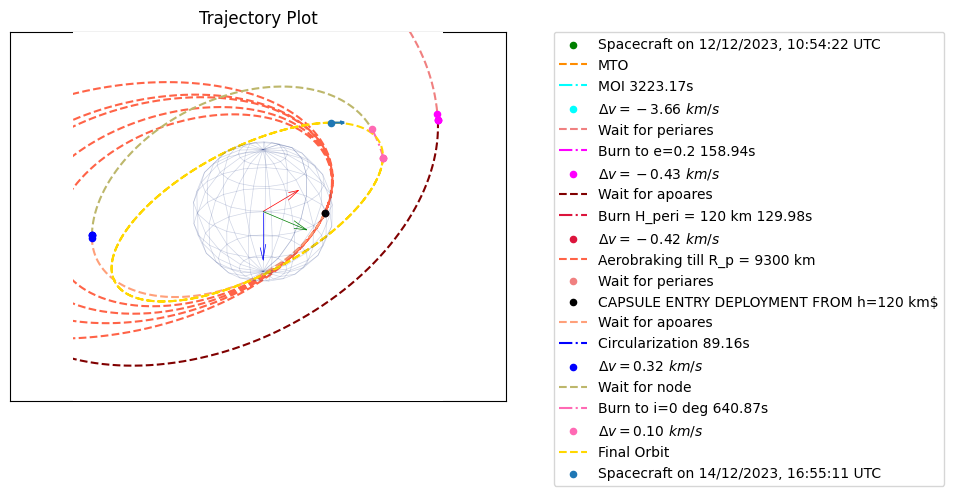

In [72]:
plot_trajectory_mars(trajectories=maneuver, body=sat, scale=1.5, x_view_angle=-40, y_view_angle=210, save="close.svg")

In [65]:
sat.mass

131.22426857798678

In [13]:
norm(get_eccentricity_vector(sat.pos, sat.vel))

0.6026203084695259

In [31]:
h = np.cross(sat.pos, sat.vel)
i = np.degrees(np.arccos(np.dot(h, np.array([0,1,0])) / (norm(h))))
i

148.56221280457632

In [32]:
180 - i

31.43778719542368